Much of the approach given below is inspired from Jeremy Howard's Fast.Ai course. 
I've mainly focussed on model interpretation using Permutation Feature Importance, Partial Dependence Plots and SHAP values.

In [1]:
#!pip install --upgrade pip
!pip install fastai==0.7.0 ## Based on Fast.ai ML course

%load_ext autoreload
%autoreload 2
%matplotlib inline

     |████████████████████████████████| 122kB 2.8MB/s 
     |████████████████████████████████| 496.4MB 72kB/s 
ERROR: allennlp 0.8.4 requires awscli>=1.11.91, which is not installed.
ERROR: allennlp 0.8.4 requires flaky, which is not installed.
ERROR: allennlp 0.8.4 requires responses>=0.7, which is not installed.
ERROR: torchvision 0.3.0 has requirement torch>=1.1.0, but you'll have torch 0.3.1 which is incompatible.
ERROR: pytorch-pretrained-bert 0.6.2 has requirement torch>=0.4.1, but you'll have torch 0.3.1 which is incompatible.
ERROR: allennlp 0.8.4 has requirement torch>=0.4.1, but you'll have torch 0.3.1 which is incompatible.
  Found existing installation: torch 1.1.0
    Uninstalling torch-1.1.0:
      Successfully uninstalled torch-1.1.0
  Found existing installation: fastai 1.0.57
    Uninstalling fastai-1.0.57:
      Successfully uninstalled fastai-1.0.57


In [2]:
import numpy as np 
import pandas as pd
from IPython.display import display
from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
import os
from pandas_summary import DataFrameSummary
from matplotlib import pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
import re

import shap
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox import pdp, get_dataset, info_plots

import IPython
from IPython.display import display
print(os.listdir("../input/"))

/opt/conda/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future versi

['train.csv', 'gender_submission.csv', 'test.csv']


/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [3]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


We'll just use a Random Forest Classifier. For that, we need to convert all columns to numeric type. But there are some categorical variables too.

In [5]:
train_cats(train_df)
apply_cats(test_df, train_df)

We'll replace categories with their numeric codes, handle missing continuous values, and split the dependent variable into a separate variable. Fastai to the rescue again !!

In [6]:
df_trn, y_trn, nas = proc_df(train_df, 'Survived')
df_test, _, _ = proc_df(test_df, na_dict=nas)
df_trn.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_na
0,1,3,109,2,22.0,1,0,524,7.2500,0,3,False
1,2,1,191,1,38.0,1,0,597,71.2833,82,1,False
2,3,3,354,1,26.0,0,0,670,7.9250,0,3,False
3,4,1,273,1,35.0,1,0,50,53.1000,56,3,False
4,5,3,16,2,35.0,0,0,473,8.0500,0,3,False


In [7]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_na,Fare_na
0,892,3,434,2,34.5,0,0,0,7.8292,0,2,False,False
1,893,3,0,1,47.0,1,0,0,7.0000,0,3,False,False
2,894,2,0,2,62.0,0,0,0,9.6875,0,2,False,False
3,895,3,0,2,27.0,0,0,0,8.6625,0,3,False,False
4,896,3,0,1,22.0,1,1,252,12.2875,0,3,False,False


In [8]:
## Let's remove the NA columns that were introduced by proc_df as the test and train datasets have different no of columns
df_trn.drop(['Age_na'], axis =1, inplace = True)
df_test.drop(['Age_na', 'Fare_na'], axis =1, inplace = True)
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,434,2,34.5,0,0,0,7.8292,0,2
1,893,3,0,1,47.0,1,0,0,7.0000,0,3
2,894,2,0,2,62.0,0,0,0,9.6875,0,2
3,895,3,0,2,27.0,0,0,0,8.6625,0,3
4,896,3,0,1,22.0,1,1,252,12.2875,0,3


### Defining function to calculate the evaluation metric

In [9]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(train_X), train_y), rmse(m.predict(val_X), val_y),     ## RMSE of log of prices
                m.score(train_X, train_y), m.score(val_X, val_y)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

### Split the data into training and validation sets

In [10]:
train_X, val_X, train_y, val_y = train_test_split(df_trn, y_trn, test_size=0.33, random_state=42)

We can now pass this processed data frame to Random Forest Regressor

Initially, let's just fit a single decision tree to visualize it properly

In [11]:
%time
m = RandomForestClassifier(n_estimators=1, min_samples_leaf=10, n_jobs=-1, max_depth = 3, oob_score=True) ## Use all CPUs available
m.fit(train_X, train_y)

print_score(m)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.3 µs
[0.5309229648742578, 0.5554048759879467, 0.7181208053691275, 0.6915254237288135, 0.6426174496644296]


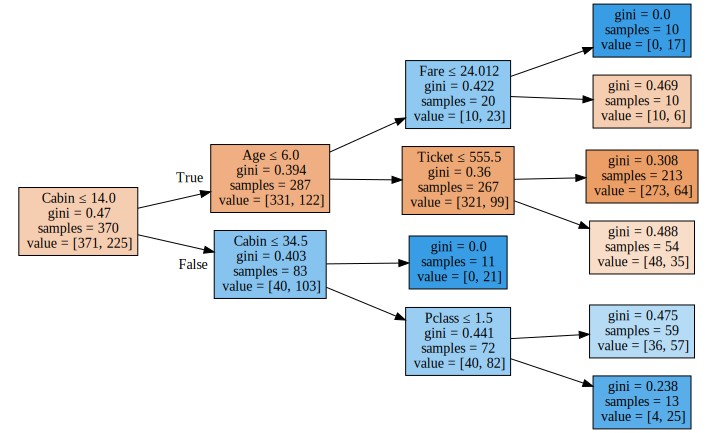

In [12]:
draw_tree(m.estimators_[0], train_X, precision=3)

A single decision tree did not perform so badly. You can read more about the gini impurity metric [here](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity).

Now, let's bag a collection of trees to create a random forest.

In [13]:
%time
m = RandomForestClassifier(n_estimators=20, min_samples_leaf=10, max_features=0.7, n_jobs=-1, oob_score=True) ## Use all CPUs available
m.fit(train_X, train_y)

print_score(m)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10.3 µs
[0.36865436423356823, 0.4317877695883728, 0.8640939597315436, 0.8135593220338984, 0.7818791946308725]


## Permuation importance of features

In [14]:
perm = PermutationImportance(m, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Weight,Feature
0.1776 ± 0.0259,Sex
0.0515 ± 0.0248,Pclass
0.0190 ± 0.0092,Cabin
0.0136 ± 0.0043,Age
0.0102 ± 0.0121,Name
0.0081 ± 0.0140,Fare
0.0061 ± 0.0100,PassengerId
0.0027 ± 0.0027,Embarked
0.0027 ± 0.0179,Ticket
0.0007 ± 0.0027,Parch


It seems that some features like Parch, Cabin, Fare & Embarked are contributing negatively to the model. We can try and drop them to see if the performance improves. Before that, let's also check the partial dependence plots for each feature.

## Partial Dependence Plots

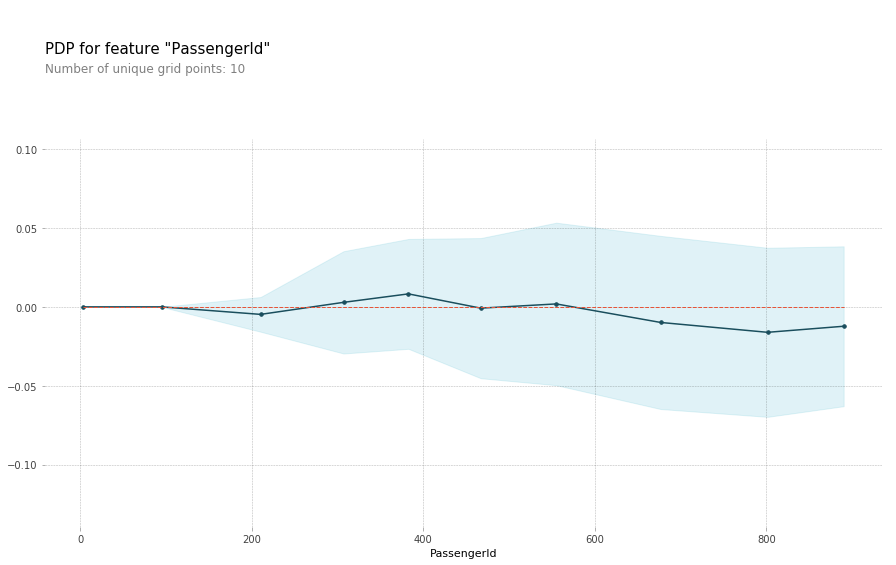

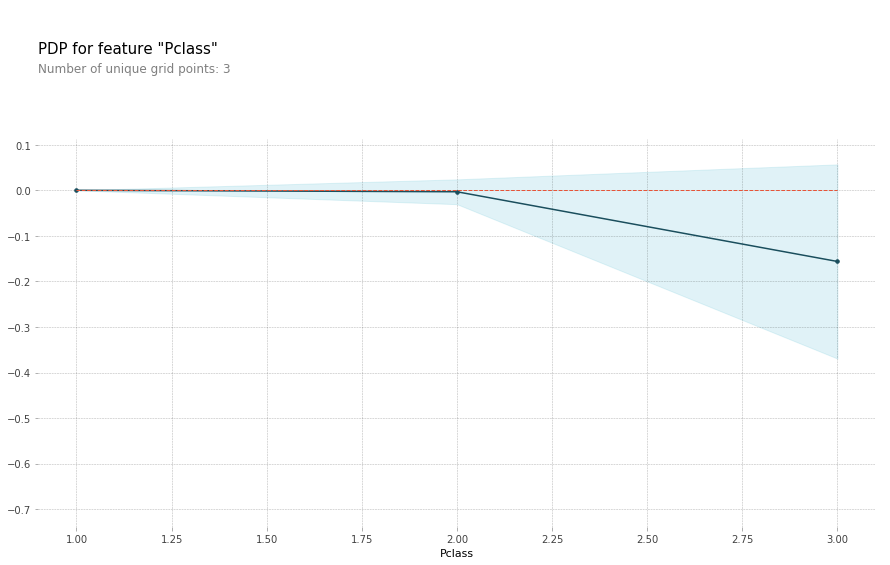

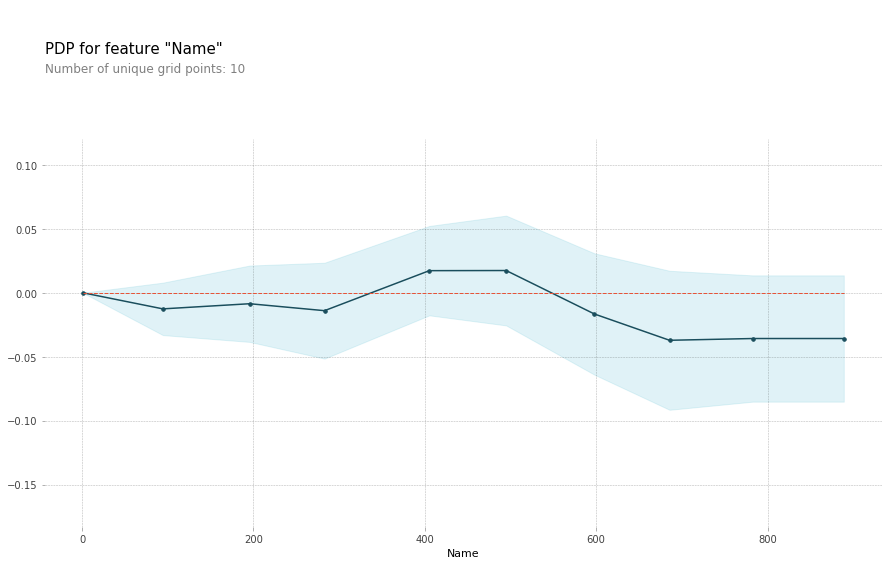

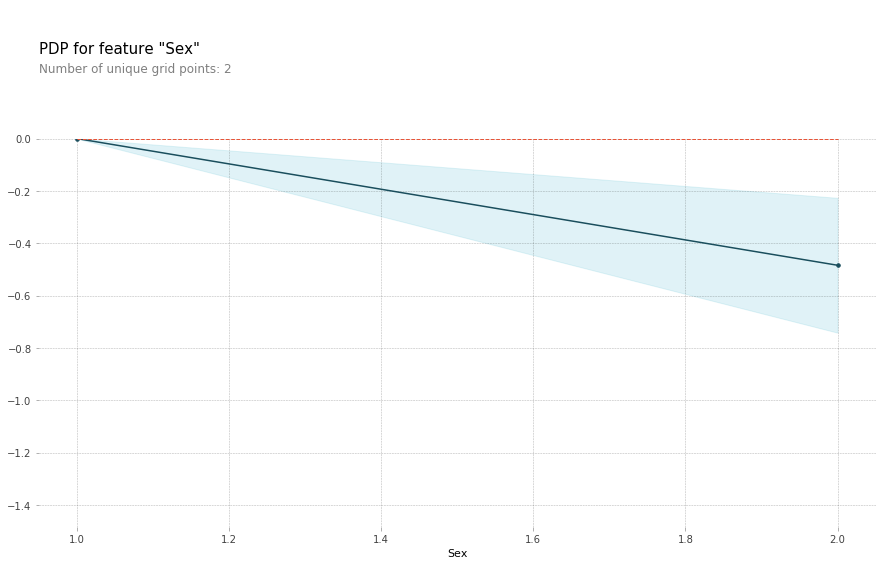

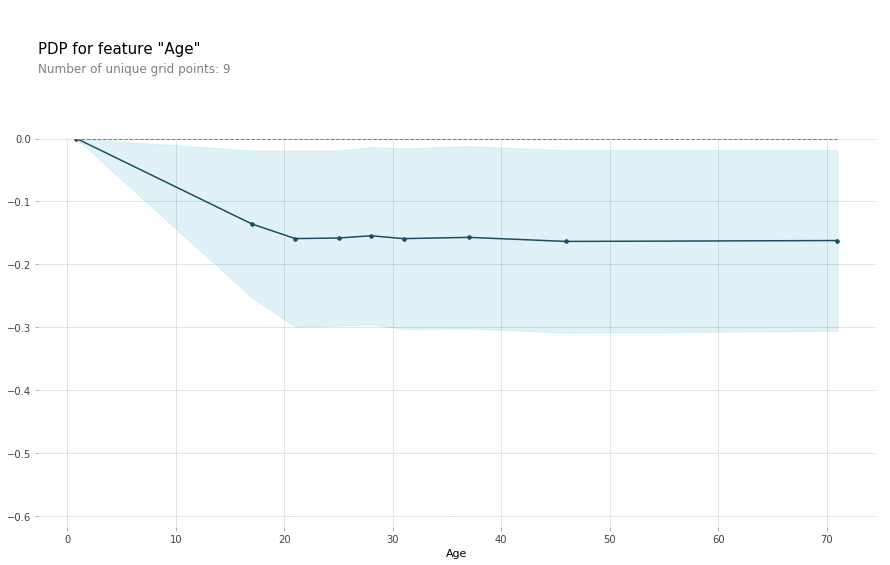

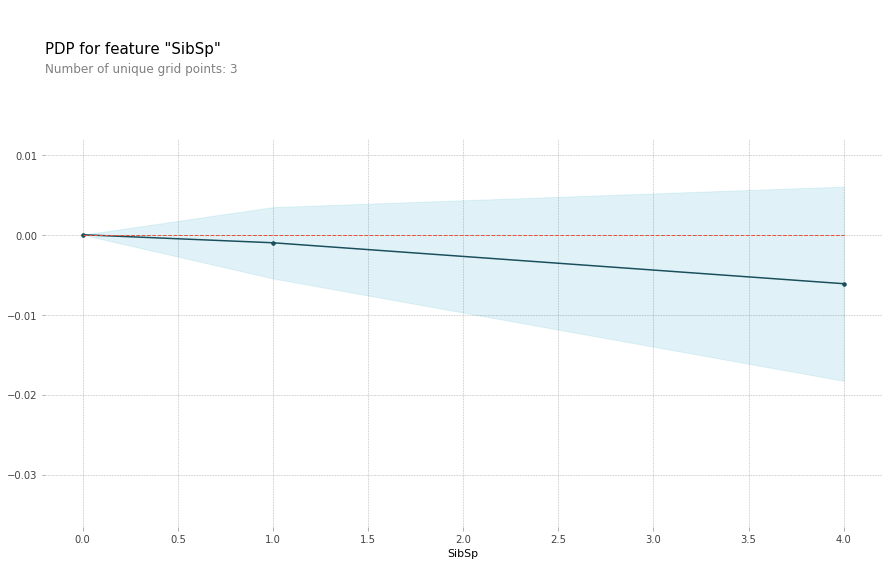

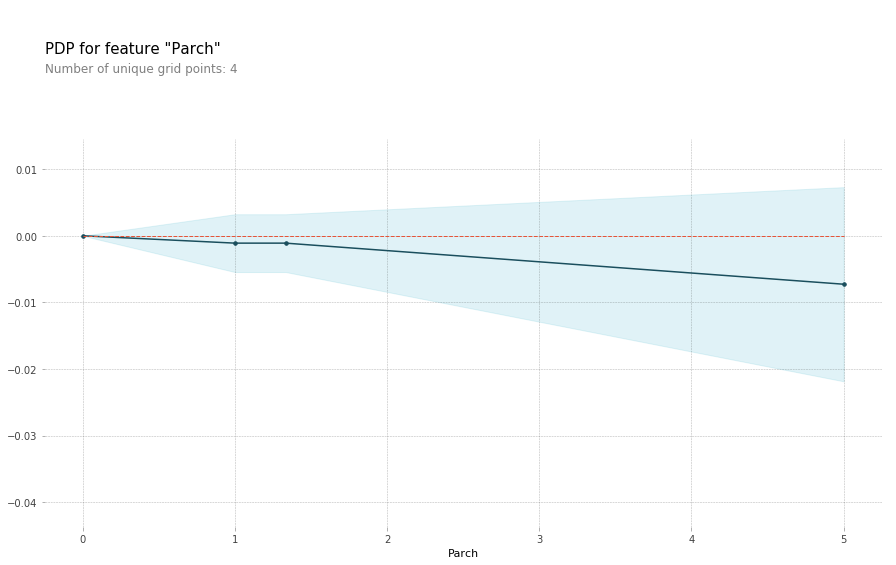

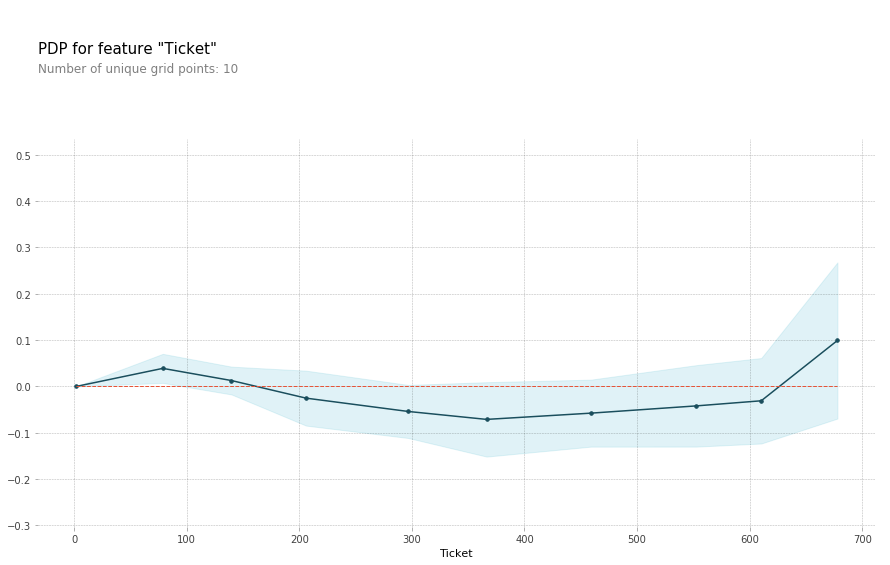

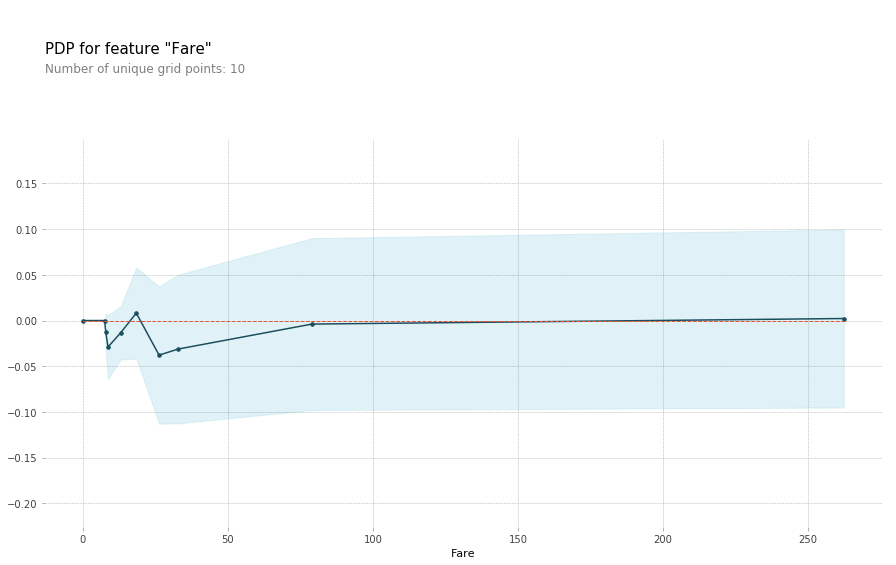

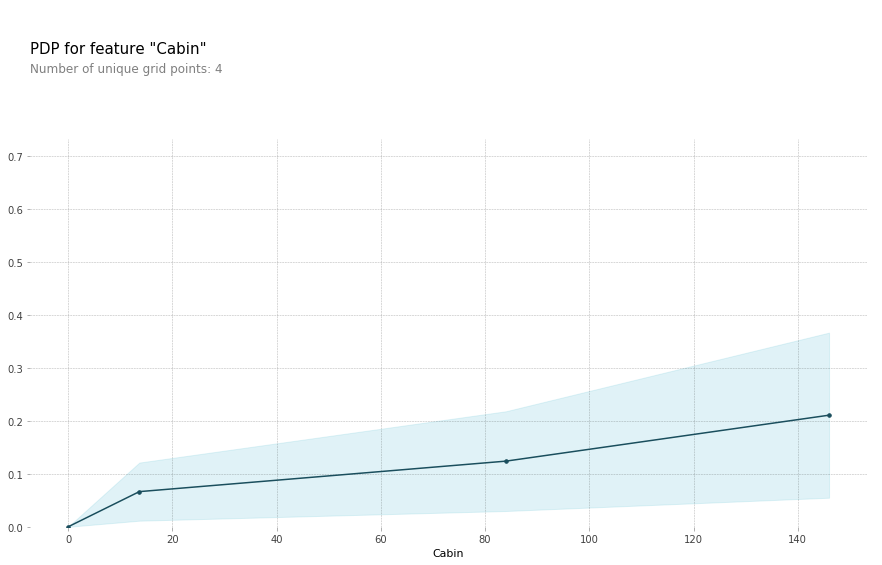

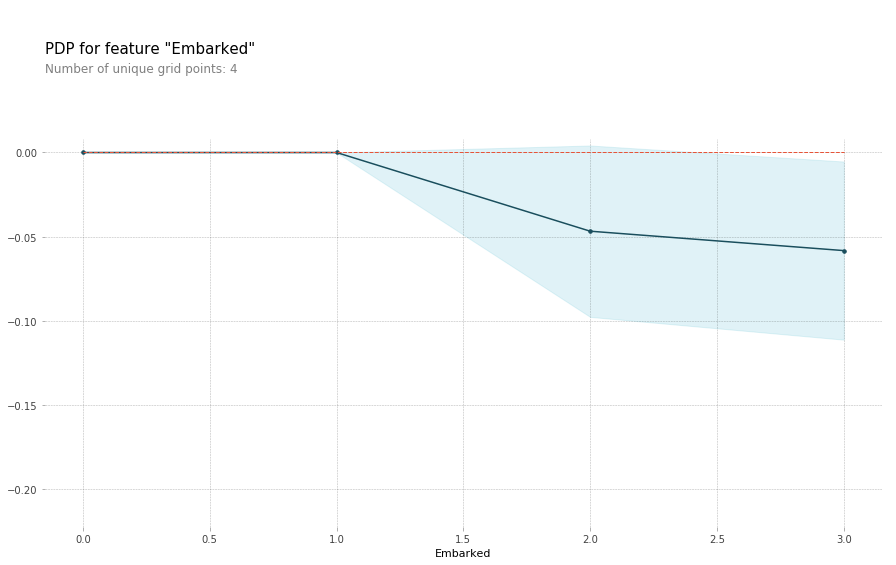

In [15]:
for feat_name in val_X.columns:
#for feat_name in base_features:
    #pdp_dist = pdp.pdp_isolate(model=m, dataset=val_X, model_features=base_features, feature=feat_name)
    pdp_dist = pdp.pdp_isolate(model = m, dataset=val_X, model_features=val_X.columns, feature=feat_name)

    pdp.pdp_plot(pdp_dist, feat_name)

    plt.show()

## SHAP values for selected rows

In [16]:
explainer = shap.TreeExplainer(m)
shap_values = explainer.shap_values(val_X)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
# shap.force_plot(explainer.expected_value, shap_values[1,:], val_X.iloc[1,:], matplotlib=True) ## Not for classification

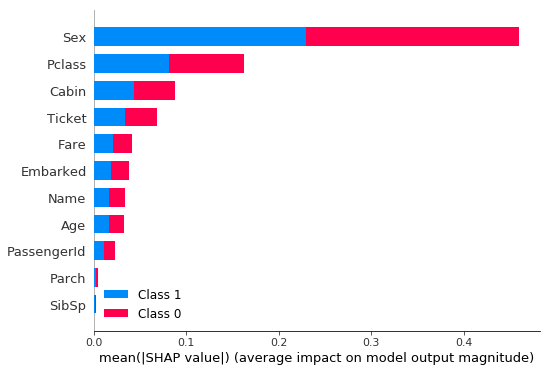

In [17]:
shap.summary_plot(shap_values, val_X, plot_type="bar")

### Updating model to remove less important features

In [18]:
%time
df_trn.drop(['Embarked', 'Fare', 'Cabin', 'Parch'], axis =1, inplace = True)
df_test.drop(['Embarked', 'Fare', 'Cabin', 'Parch'], axis =1, inplace = True)
train_X, val_X, train_y, val_y = train_test_split(df_trn, y_trn, test_size=0.33, random_state=42)
m = RandomForestClassifier(n_estimators=20, min_samples_leaf=10, max_features=0.7, n_jobs=-1, oob_score=True) ## Use all CPUs available
m.fit(train_X, train_y)
print_score(m)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 12.9 µs
[0.37986221451129204, 0.435695430862634, 0.8557046979865772, 0.8101694915254237, 0.8003355704697986]


Not much difference in the RMSE score, but we did see a slight improvement in the validation set accuracy and the OOB score.
Let's make predictions on the test set using this model !

## Submitting Predictions

In [19]:
pred = m.predict(df_test)
submission = pd.read_csv('../input/gender_submission.csv')
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [20]:
submission['Survived'] = pred   
submission.to_csv('rf_submission_v2.csv', index=False)